# Задание 2 - Перенос обучения (transfer learning) и тонкая настройка (fine-tuning)

Одна из важнейшних техник в тренировке сетей - использовать заранее натренированные веса на более общей задаче в качестве начальной точки, а потом "дотренировать" их на конкретной.

Такой подход и убыстряет обучение, и позволяет тренировать эффективные модели на маленьких наборах данных.

В этом упражнении мы натренируем классификатор, который отличает хотдоги от не хотдогов!  

Это задание требует доступа к GPU, поэтому его можно выполнять либо на компьютере с GPU от NVidia, либо в [Google Colab](https://colab.research.google.com/).

In [1]:
import json
import os
import csv
import urllib
import cv2
from io import BytesIO
from PIL import Image

from socket import timeout

#from google.colab import files

# !pip install torch 
# !pip install torchvision
# !pip install Pillow

Сначала давайте скачаем данные с картинками. Это сделает код в следующей ячейке. Данные будут разделены на две части. На обучающей выборке, которая будет храниться в папке **train_kaggle**, мы будем строить наши модели, а на тестовой выборке **test_kaggle** будем предсказывать класс, к которому относится фотография (хотдог или нет).

### Если вы в Google Colab!

В нем можно запускать ноутбуки с доступом к GPU. Они не очень быстрые, зато бесплатные!
Каждый ноутбук получает свой собственный environment c доступным диском итд.

Через 90 минут отсуствия активности этот environment пропадает со всеми данными.
Поэтому нам придется скачивать данные каждый раз.

In [2]:
# Download train data
#!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
#!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
#!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
#!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

Number of files in the train folder 4603
Number of files in the test folder 1150


In [70]:
train_folder

'train_kaggle/'

In [5]:
train_folder = "train_kaggle"
test_folder = "test_kaggle"

In [3]:
#example = '/home/malleo/ML/DL/Lection 5/HotDog or not/train_kaggle/chili-dog_7566.jpg'

In [3]:
import torch
import torchvision
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler
from torchvision import transforms
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:0") # Let's make sure GPU is available!

# Имплементируем свой Dataset для загрузки данных

В этом задании мы реализуем свой собственный класс Dataset для загрузки данных. Его цель - загрузить данные с диска и выдать по ним тензор с входом сети, меткой и идентификатором картинки.

Вот ссылка, где хорошо объясняется как это делать на примере: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Ваш Dataset должен в качестве количества сэмплов выдать количество файлов в папке и уметь выдавать кортеж из сэмпла, метки по индексу и названия файла.
Если название файла начинается со слов 'frankfurter', 'chili-dog' или 'hotdog' - метка положительная. Иначе отрицательная (ноль).

И не забудьте поддержать возможность трансформации входа (аргумент `transforms`), она нам понадобится!

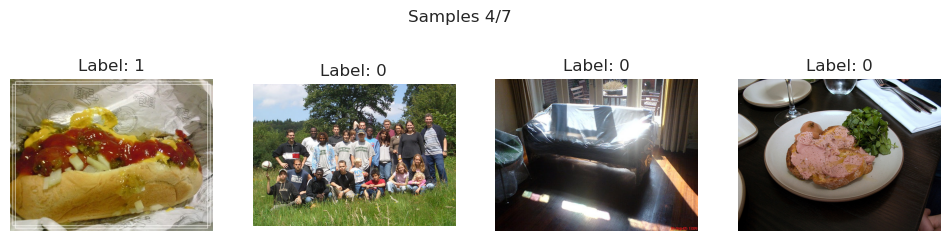

In [6]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        
        # TODO: Your code here!
        self.folder = folder
        self.list_folder = os.listdir(folder)
        
    def __len__(self):
        # TODO
        return len(self.list_folder)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        y = 1 if "frankfurter" in self.list_folder[index] or "chili-dog" in self.list_folder[index] or "hotdog" in self.list_folder[index] else 0

        img_path = os.path.join(self.folder, self.list_folder[index])
        img_id = self.list_folder[index]
        
        
        
        
        img = Image.open(img_path)

        #img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = img.astype(np.float32)
        #img = img/255.0

        #img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        #img = img.transpose((2, 0, 1))

        t_img = img
        #t_img = torch.from_numpy(img)
        #t_img = t_img.squeeze().permute(1,2,0)
        t_class_id = y
        #t_class_id = torch.tensor(y)
        
        
        if self.transform:
            #t_img = torch.from_numpy(img)
            t_img = self.transform(t_img) 
        
        return t_img, t_class_id, img_id

def visualize_samples(dataset, indices, title=None, count=4):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')   


train_folder = "/home/malleo/ML/DL/Lection 5/HotDog or not/train_kaggle"    
orig_dataset = HotdogOrNotDataset(train_folder)
indices = np.random.choice(np.arange(len(orig_dataset)), 7, replace=False)

visualize_samples(orig_dataset, indices, "Samples")

In [215]:
type(indices)

numpy.ndarray

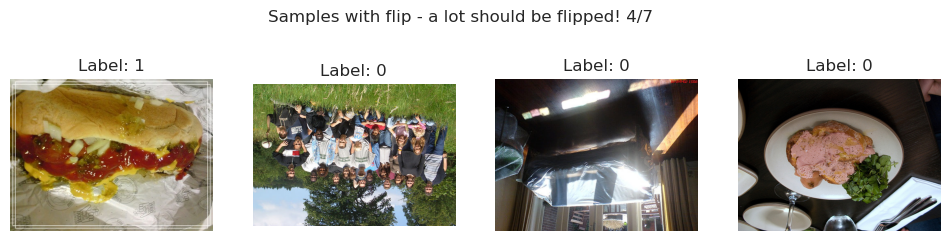

In [7]:
# Let's make sure transforms work!
dataset = HotdogOrNotDataset(train_folder, transform=transforms.RandomVerticalFlip(p=0.9))

visualize_samples(dataset, indices, "Samples with flip - a lot should be flipped!")

# Создаем Dataset для тренировки

И разделяем его на train и validation.
На train будем обучать модель, на validation проверять ее качество, а соревнование Kaggle In-Class проведем на фотографиях из папки test_kaggle.

In [8]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset(train_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_dataset = HotdogOrNotDataset(test_folder, 
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )

In [9]:
batch_size = 64

data_size = len(dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)
# Notice that we create test data loader in a different way. We don't have the labels.
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [9]:
len(train_dataset)

4603

Наши обычные функции для тренировки

In [10]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y,_) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def compute_accuracy(model,loader):

    model.eval() # Evaluation mode

    valid_loss_values = []
    valid_loss_acc = []

    running_loss = []
    running_acc = []

    with torch.no_grad():
        for i_step, (x, y, _) in enumerate(val_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            #        print(prediction)
            loss_value = loss(prediction, y_gpu)
            #        print(loss_value)
            acc_value = (prediction.cpu().argmax(dim=1)==y_gpu.cpu()).sum()/len(y_gpu)
            #        print(acc_value)
            # 
            running_loss.append(loss_value.item())
            #        print(running_loss)
            running_acc.append(acc_value)
        #   print(running_acc)
    # 
    valid_loss_values.append(np.mean(running_loss))
    valid_loss_acc.append(np.mean(running_acc))

    return valid_loss_acc[0]


# Использование заранее натренированной сети (pretrained network)

Чаще всего в качестве заранее натренированной сети используется сеть, натренированная на данных ImageNet с 1M изображений и 1000 классами.

PyTorch включает такие натренированные сети для различных архитектур (https://pytorch.org/vision/stable/models.html)  
Мы будем использовать ResNet18.

Для начала посмотрим, что выдает уже натренированная сеть на наших картинках. То есть, посмотрим к какому из 1000 классов их отнесет сеть.

Запустите модель на 10 случайных картинках из датасета и выведите их вместе с классами с наибольшей вероятностью.  
В коде уже есть код, который формирует соответствие между индексами в выходном векторе и классами ImageNet.

In [11]:
# Thanks to https://discuss.pytorch.org/t/imagenet-classes/4923/2
def load_imagenet_classes():
    classes_json = urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json').read()
    classes = json.loads(classes_json)
    
    # TODO: Process it to return dict of class index to name
    return { int(k): v[-1] for k, v in classes.items()}
    
model = models.resnet18(pretrained=True)
#model = model.to(device)

# TODO: Run this model on 10 random images of your dataset and visualize what it predicts

In [12]:
def image_shower(images, labels, n=10):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        #image = image*255
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        #plt.imshow(image.numpy().astype("uint8").transpose((1,2,0)).squeeze())
        #plt.imshow(image.numpy().astype("uint8"))
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("not_hot_dog","hotdog")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Real Labels:  hotdog not_hot_dog not_hot_dog not_hot_dog hotdog not_hot_dog not_hot_dog not_hot_dog hotdog hotdog
Predicted:  hotdog  file broccoli crayfish lampshade matchstick meat_loaf golfcart hourglass conch


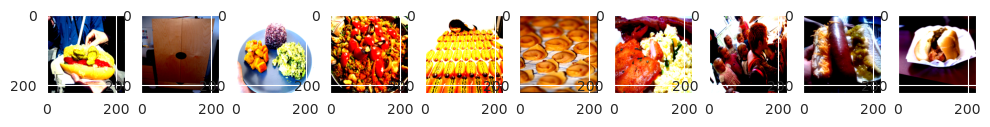

In [13]:
images, labels, _ = next(iter(train_loader))
image_shower(images, labels)

outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %load_imagenet_classes()[int(predict)] for predict in predicted[:10] ))

# Перенос обучения (transfer learning) - тренировать только последний слой

Существует несколько вариантов переноса обучения, мы попробуем основные.  
Первый вариант - заменить последний слой на новый и тренировать только его, заморозив остальные.

In [14]:
import torch.nn as nn
import torch.optim as optim


# TODO: Freeze all the layers of this model and add a new output layer
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

#parameters = model.parameters()   # Fill the right thing here!

for param in model.parameters():
    param.require = False


In [15]:
class RetrofittedResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        pretrained_net = torchvision.models.squeezenet1_1(
            pretrained=True,
            num_classes=1000)
        self.ResNet18 = pretrained_net.features

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 2)
        )

    def forward(self, images):
        """
        Define the forward pass.
        """
        features = self.ResNet18(images).mean([2, 3])
        return self.classifier(features)

In [16]:
torch.manual_seed(666)
model = RetrofittedResNet().to(device)
model.ResNet18.requires_grad_(False);

In [17]:
#model.fc = nn.Linear(512,2)

#model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 2)

Average loss: 0.506152, Train accuracy: 0.750747, Val accuracy: 0.842708
Average loss: 0.374659, Train accuracy: 0.827858, Val accuracy: 0.861458



# Перенос обучения (transfer learning) - тренировать всю модель

Второй вариант - точно так же заменить последний слой на новый и обучать всю модель целиком.

In [17]:
import torch.nn as nn
import torch.optim as optim

#model = models.resnet18(pretrained=True)
# TODO: Add a new output layer and train the whole model
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model.requires_grad_(True)
#trinable_parameters = model.parameters()   # Fill the right thing here!

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD( model.parameters(), lr=0.001, momentum=0.9)
#model = model.to(device)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.310338, Train accuracy: 0.859354, Val accuracy: 0.897569
Average loss: 0.260999, Train accuracy: 0.890035, Val accuracy: 0.911806
Average loss: 0.235922, Train accuracy: 0.900353, Val accuracy: 0.928472
Average loss: 0.219052, Train accuracy: 0.912571, Val accuracy: 0.929514
Average loss: 0.189345, Train accuracy: 0.923160, Val accuracy: 0.920833


# Перенос обучения (transfer learning) - разные скорости обучения для разных слоев

И наконец последний вариант, который мы рассмотрим - использовать разные скорости обучения для новых и старых слоев

In [48]:
import torch.nn as nn
import torch.optim as optim

#model = models.resnet18(pretrained=True)
# TODO: Add a new output layer
# Train new layer with learning speed 0.001 and old layers with 0.0001
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

loss = nn.CrossEntropyLoss()

optimizer = optim.SGD([
    #{'params': model.features.parameters()},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
], lr=1e-4, momentum=0.9) # Hint - look into what PyTorch optimizers let you configure!
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.165846, Train accuracy: 0.932664, Val accuracy: 0.921181
Average loss: 0.171240, Train accuracy: 0.932392, Val accuracy: 0.928472
Average loss: 0.170290, Train accuracy: 0.934564, Val accuracy: 0.928819
Average loss: 0.153752, Train accuracy: 0.943253, Val accuracy: 0.931250
Average loss: 0.165175, Train accuracy: 0.933478, Val accuracy: 0.928125


# Визуализируем метрики и ошибки модели

Попробуем посмотреть, где модель ошибается - визуализируем ложные срабатывания (false positives) и ложноотрицательные срабатывания (false negatives).

Для этого мы прогоним модель через все примеры и сравним ее с истинными метками (ground truth).

In [18]:
from torch.utils.data.sampler import Sampler

class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        data_source (Dataset): dataset to sample from
        indices (ndarray): indices of the samples to take
    """
    

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of booleans of model predictions
    grount_truth: np array of boolean of actual labels of the dataset
    
    """
    model.eval() # Evaluation mode
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    predictions = np.array([])
    ground_truth = np.array([])

    for i, data in enumerate (train_dataset):


        inputs, label, name = data
        inputs_gpu = inputs.to(device)
        label = label

        outputs = model(inputs_gpu.unsqueeze(0))
        predictions = np.append(predictions, outputs.cpu().argmax(dim=1).numpy())
        ground_truth = np.append(ground_truth,label)
    
    
    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

In [170]:
# predictions = np.array([])
# ground_truth = np.array([])
# 
# for i, data in enumerate (train_dataset):
#     
#     #print(data)
# 
#     inputs, label, name = data
#     inputs_gpu = inputs.to(device)
#     label = label
#     #print(f"label {label}")
#     
#     #print(inputs)
# 
#     outputs = model(inputs_gpu.unsqueeze(0))
#     predictions = np.append(predictions, outputs.cpu().argmax(dim=1).numpy())
#     # 
#     #print(label)
#     ground_truth = np.append(ground_truth,label)

И теперь можно визуализировать false positives и false negatives.

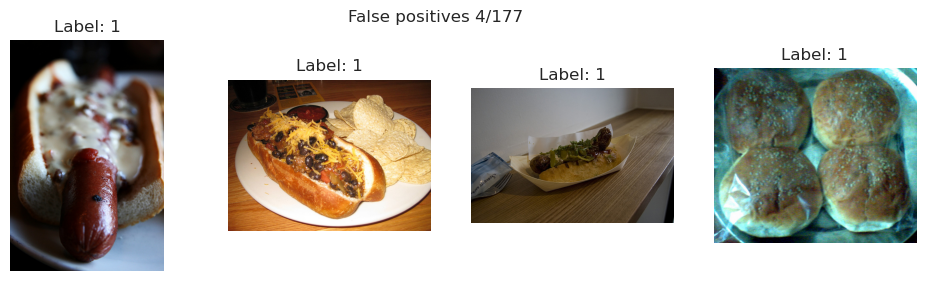

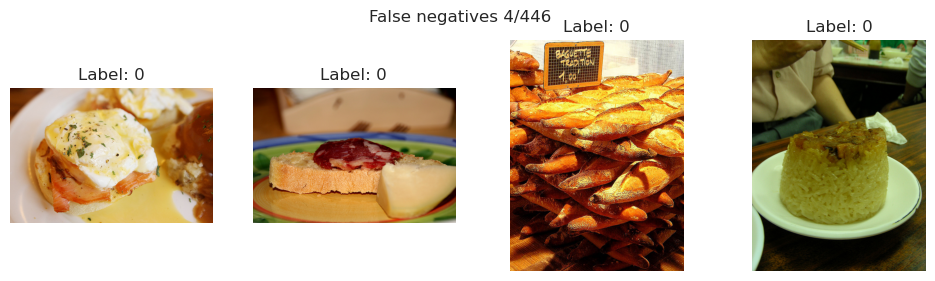

In [19]:
# TODO: Compute indices of the false positives on the validation set.
# Note those have to be indices of the original dataset
false_positive_indices = (np.array(np.where((predictions == 0) & (gt == 1)))).reshape(-1)
visualize_samples(orig_dataset, false_positive_indices, "False positives")

# TODO: Compute indices of the false negatives on the validation set.
# Note those have to be indices of the original dataset
false_negatives_indices = (np.array(np.where((predictions == 1) & (gt == 0)))).reshape(-1)
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")


In [35]:
import sklearn.metrics as metrics
def binary_classification_metrics(prediction, ground_truth):
    # TODO: Implement this function!
    # We did this already it in the assignment1
    precision = metrics.precision_score(predictions, ground_truth, average='macro')
    recall = metrics.recall_score(predictions, ground_truth, average='macro')
    f1 = metrics.f1_score(predictions, ground_truth, average='macro')
    
    return precision, recall, f1

precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.850, P: 0.868, R: 0.839


# Что будет в конце вы уже поняли

Натренируйте лучшую модель на основе `resnet18`, меняя только процесс тренировки.
Выбирайте лучшую модель по F1 score.

Как всегда, не забываем:
- побольше аугментаций!
- перебор гиперпараметров
- различные оптимизаторы
- какие слои тюнить
- learning rate annealing
- на какой эпохе останавливаться

Наша цель - довести F1 score на validation set до значения, большего **0.93**.

In [ ]:
# TODO: Train your best model!
best_model = None

In [ ]:
# Let's check how it performs on validation set!
predictions, ground_truth = evaluate_model(best_model, dataset, val_indices)
precision, recall, f1 = binary_classification_metrics(predictions, ground_truth)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (precision, recall, f1))

# TODO: Visualize training curve for the best model

## Визуализируйте ошибки лучшей модели

# TODO Visualize false positives and false negatives of the best model on the validation set